Build an RNN with an LSTM layer for Nvidia stock prediction and complete the training, testing, and prediction steps.

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers


import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [34]:
data = pd.read_csv('NVDA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-22,19.650000,19.650000,19.17,19.410000,18.851749,8911800
1,2015-07-23,19.450001,19.940001,19.41,19.650000,19.084845,4247900
2,2015-07-24,19.790001,19.809999,19.34,19.420000,18.861464,4721100
3,2015-07-27,19.250000,19.530001,19.09,19.309999,18.754622,4810500
4,2015-07-28,19.360001,19.860001,19.16,19.730000,19.162542,4957700


Training data = 2015-07-22 to 2019-01-01


Test_data = 2019-01-01 to 2020-07-21



In [35]:
# create train & test data using columns
train_data = data[data['Date']<'2019-01-01'].copy()
test_data = data[data['Date']>='2019-01-01'].copy()

# drop DATE & ADJ CLOSE columns
train_data = train_data.drop(['Date', 'Adj Close'], axis=1)
test_data = test_data.drop(['Date', 'Adj Close'], axis=1)

train_data.head()

,Open,High,Low,Close,Volume
0,19.650000,19.650000,19.17,19.410000,8911800
1,19.450001,19.940001,19.41,19.650000,4247900
2,19.790001,19.809999,19.34,19.420000,4721100
3,19.250000,19.530001,19.09,19.309999,4810500
4,19.360001,19.860001,19.16,19.730000,4957700


In [36]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_train_data[:10]

array([[0.0014811 , 0.00043919, 0.0003002 , 0.00037031, 0.08351206],
       [0.00074055, 0.00150057, 0.0012008 , 0.00125903, 0.03226717],
       [0.00199949, 0.00102477, 0.00093812, 0.00040734, 0.03746649],
       [0.        , 0.        , 0.        , 0.        , 0.03844878],
       [0.00040731, 0.00120777, 0.00026267, 0.00155527, 0.04006615],
       [0.00162921, 0.00219594, 0.0019513 , 0.00244399, 0.04950776],
       [0.00248084, 0.00252534, 0.00311456, 0.00262915, 0.03783347],
       [0.00314733, 0.00212275, 0.00277684, 0.00236994, 0.04556872],
       [0.00318436, 0.00285473, 0.00285189, 0.00362897, 0.09468092],
       [0.00359166, 0.00329392, 0.00394011, 0.00392521, 0.05703973]])

In [37]:
# no of rows in the train_data
scaled_train_data.shape[0]

868

Prepare training data & predictionn value


The first dataset of X_train would contain 60 days of training (0-60), second strip would be days (1-61) etc

The first dataset of Y_train would be the 61st day, second would be day 62nd.

In [38]:
X_train, Y_train = [], []

for i in range(60, scaled_train_data.shape[0]):
    X_train.append(scaled_train_data[i-60:i])
    Y_train.append(scaled_train_data[i, 0])

# convert training data to numpy
X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape, Y_train.shape)
# X_train contains 808 observations, 60 days of data for 5 features
# Y_train contains the CLOSING of the next day for each observation

(808, 60, 5) (808,)


In [39]:
# build the ANN
regressor = Sequential([
    # input is Sequences of 60 days with 5 features
    layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 5)),
    layers.Dropout(0.2),
    layers.LSTM(60, activation='relu', return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(80, activation='relu', return_sequences=True),
    layers.Dropout(0.4),
    layers.LSTM(120, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 120)              

In [40]:
# train the ANN
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, Y_train, epochs=10, batch_size=32)


Epoch 1/10
26/26 [==============================] - 9s 147ms/step - loss: 0.1185
Epoch 2/10
26/26 [==============================] - 4s 149ms/step - loss: 0.0212
Epoch 3/10
26/26 [==============================] - 4s 148ms/step - loss: 0.0146
Epoch 4/10
26/26 [==============================] - 4s 154ms/step - loss: 0.0114
Epoch 5/10
26/26 [==============================] - 4s 143ms/step - loss: 0.0106
Epoch 6/10
26/26 [==============================] - 4s 143ms/step - loss: 0.0101
Epoch 7/10
26/26 [==============================] - 4s 145ms/step - loss: 0.0090
Epoch 8/10
26/26 [==============================] - 4s 150ms/step - loss: 0.0085
Epoch 9/10
26/26 [==============================] - 4s 150ms/step - loss: 0.0085
Epoch 10/10
26/26 [==============================] - 4s 151ms/step - loss: 0.0080


Beginning process to Test our model

In [32]:
# peak the TEST dataset
test_data.head()

,Open,High,Low,Close,Volume
868,130.639999,138.479996,130.050003,136.220001,12718800
869,133.789993,135.160004,127.690002,127.989998,17638800
870,130.940002,137.729996,129.699997,136.190002,14640500
871,138.500000,144.889999,136.429993,143.399994,17729000
872,146.690002,146.779999,136.899994,139.830002,19650400


In [41]:
# use TAIL method to get last 60_days of TRAIN_DATA which would be appended to TEST_DATA
past_60_days = train_data.tail(60)
df = past_60_days.append(test_data, ignore_index=True)
df.head()

,Open,High,Low,Close,Volume
0,285.269989,286.250000,276.179993,279.290009,9780500
1,278.290009,280.799988,267.540009,269.859985,10665900
2,266.500000,271.160004,260.079987,265.769989,10215300
3,264.940002,268.760010,262.799988,265.540009,6837500
4,261.260010,263.109985,245.600006,245.690002,17123500


In [42]:
# use Standard_Scaler which Zeros the mean & STD to 1
ss = StandardScaler().fit(df)
inputs = ss.transform(df)
inputs[:10]

array([[ 1.01051408,  0.9521051 ,  0.9567278 ,  0.92233228, -0.45004957],
       [ 0.91043198,  0.87524822,  0.83037704,  0.7873599 , -0.31030609],
       [ 0.74138151,  0.73930374,  0.72128198,  0.72881959, -0.38142469],
       [ 0.71901356,  0.70545867,  0.76105917,  0.72552788, -0.91454592],
       [ 0.66624818,  0.62578119,  0.50952734,  0.44141378,  0.70890275],
       [ 0.39252698,  0.40649297,  0.34369149,  0.29026804,  0.86869076],
       [ 0.44041736,  0.43441515,  0.42251461,  0.45357974,  0.40624621],
       [ 0.44744328,  0.38449365,  0.35948538,  0.2938463 , -0.21906404],
       [ 0.36040878,  0.38844224,  0.39750776,  0.44341761, -0.38103012],
       [ 0.48099519,  0.43921005,  0.44342699,  0.40377041, -0.69291977]])

In [43]:
# checkout the shape of the Inputs
inputs.shape

(451, 5)

In [44]:
X_test, y_test = [], []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((391, 60, 5), (391,))

In [46]:
# make some predictions
y_pred = regressor.predict(X_test)

# check the scale used by the StandardScaler
ss.scale_

array([6.97425422e+01, 7.09111845e+01, 6.83809377e+01, 6.98663222e+01,
       6.33589480e+06])

In [47]:
# set a Scale = 270.07
scale = 1/3.70274364e-03

y_pred = y_pred * scale
y_test = y_test * scale

In [48]:
y_pred[:10]


array([[-195.13055],
       [-218.87524],
       [-246.02834],
       [-277.35236],
       [-313.38586],
       [-355.48395],
       [-404.8269 ],
       [-460.76724],
       [-523.4115 ],
       [-591.9834 ]], dtype=float32)

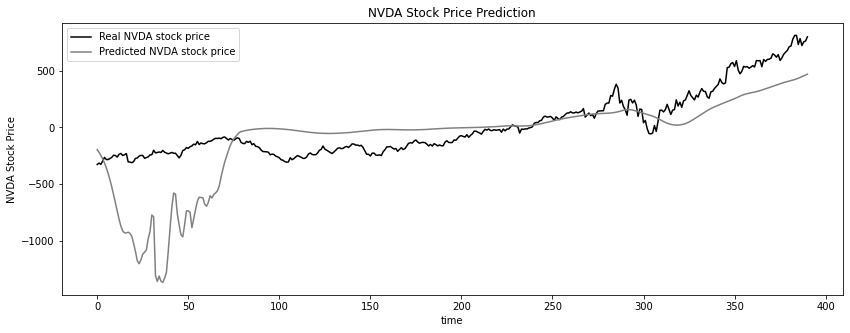

In [49]:
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='black', label='Real NVDA stock price')
plt.plot(y_pred, color='gray', label='Predicted NVDA stock price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()
